In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('historical_prices.csv')
df.head()

,state,area,year,quarter,medianAcreage,nominalPrice,nominalPercent,nominalGrowth,realPrice,realPercent,annualVolume,qtrVolume
0,Texas,Panhandle - North (LMA 1),1971,0,320,193,-19.08,-0.71,155,-22.98,59.0,NaN
1,Texas,Panhandle - North (LMA 1),1972,0,320,210,8.81,0.14,162,4.31,72.0,NaN
2,Texas,Panhandle - North (LMA 1),1973,0,560,210,0.00,0.98,153,-5.20,69.0,NaN
3,Texas,Panhandle - North (LMA 1),1974,0,480,299,42.38,8.37,200,30.59,95.0,NaN
4,Texas,Panhandle - North (LMA 1),1975,0,325,435,45.48,12.77,267,33.21,52.0,NaN


Only grab the info we care about

In [3]:
df = df[['area', 'year', 'nominalPrice']]
df = df.rename(columns={'nominalPrice': 'price_per_acre'})
df.head()

,area,year,price_per_acre
0,Panhandle - North (LMA 1),1971,193
1,Panhandle - North (LMA 1),1972,210
2,Panhandle - North (LMA 1),1973,210
3,Panhandle - North (LMA 1),1974,299
4,Panhandle - North (LMA 1),1975,435


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   area            1647 non-null   object
 1   year            1647 non-null   int64 
 2   price_per_acre  1647 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 38.7+ KB


After inspecting the data later on, I found its exponential in growth which matches with ideas about investments and land, so lets add a log_price_per_acre to help deal with this

In [5]:
df['log_price_per_acre'] = np.log(df['price_per_acre'])
df = df.drop('price_per_acre', axis=1)

### Linear regression for the menard surrounding area

In [6]:
reg = LinearRegression()

In [7]:
menard_surrounding_area = df[df['area'].str.contains('\(LMA (?:15|9|7|13|14|16|17|10)\)', regex=True)]
menard_surrounding_area['area'].unique()

array(['Rolling Plains - Central (LMA 7)',
       'Edwards Plateau - West (LMA 9)',
       'Edwards Plateau - South (LMA 10)', 'Crosstimbers (LMA 13)',
       'Hill Country - North (LMA 14)', 'Hill Country - West (LMA 15)',
       'Highland Lakes (LMA 16)', 'Hill Country - South (LMA 17)'],
      dtype=object)

In [8]:
menard_surrounding_area_with_dummies = pd.get_dummies(menard_surrounding_area)
X = menard_surrounding_area_with_dummies.drop('log_price_per_acre', axis=1)
y = menard_surrounding_area_with_dummies['log_price_per_acre']
reg.fit(X, y)
reg.score(X, y)

0.8820011218840894

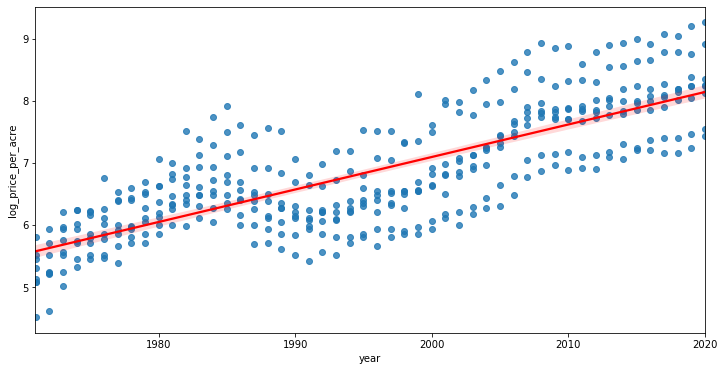

In [9]:
plt.figure(figsize=(12,6))
sns.regplot(data=menard_surrounding_area, x='year', y='log_price_per_acre', line_kws={'color': 'red'})

In [10]:
prediction_df = (pd.DataFrame(data={'year': [2020, 2040]}, 
                             columns=menard_surrounding_area_with_dummies.columns)
                  .drop('log_price_per_acre', axis=1)
                  .fillna(0))
        
preds = reg.predict(prediction_df)
np.exp(preds)

array([3428.16184557, 9766.97214958])

This indicates the current average price per acre for the menard area is `$3,428` with an expected value of `$9,766` in 2040, or an ARR of 5.37%

### Linear regression for the hill country

In [11]:
hill_country = df[df['area'].str.contains('hill country', case=False)]

In [12]:
hill_country_with_dummies = pd.get_dummies(hill_country)
X = hill_country_with_dummies.drop('log_price_per_acre', axis=1)
y = hill_country_with_dummies['log_price_per_acre']
reg.fit(X, y)
reg.score(X, y)

0.8969945228516011

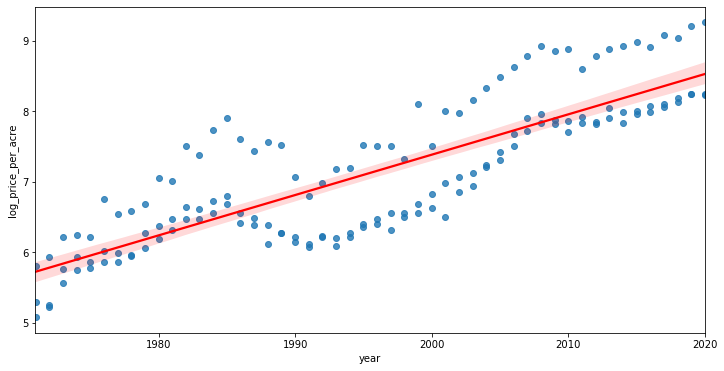

In [13]:
plt.figure(figsize=(12,6))
sns.regplot(data=hill_country, x='year', y='log_price_per_acre', line_kws={'color': 'red'})

In [14]:
prediction_df = (pd.DataFrame(data={'year': [2020, 2040]}, 
                             columns=hill_country_with_dummies.columns)
                  .drop('log_price_per_acre', axis=1)
                  .fillna(0))
        
preds = reg.predict(prediction_df)
np.exp(preds)

array([ 5063.34224967, 15929.41602275])

This indicates the current average price per acre for the hill country is `$5,063` with an expected value of `$15,929` in 2040, or an ARR of 5.9%

### Linear regression for the menard area only

In [15]:
menard_area = df[df['area'] == 'Hill Country - West (LMA 15)']

In [16]:
menard_area_with_dummies = pd.get_dummies(menard_area)
X = menard_area_with_dummies.drop('log_price_per_acre', axis=1)
y = menard_area_with_dummies['log_price_per_acre']
reg.fit(X, y)
reg.score(X, y)

0.844488697589905

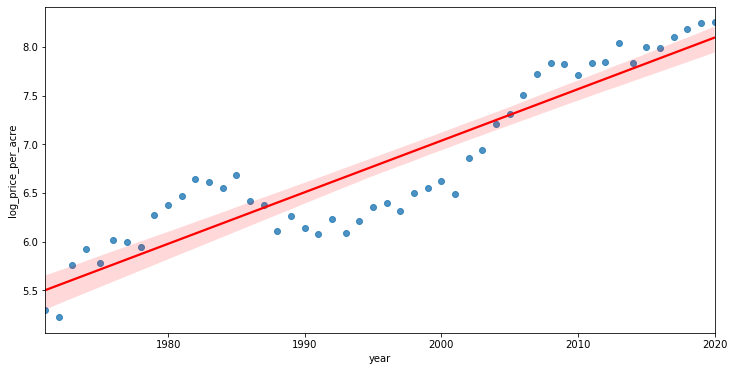

In [17]:
plt.figure(figsize=(12,6))
sns.regplot(data=menard_area, x='year', y='log_price_per_acre', line_kws={'color': 'red'})

In [18]:
prediction_df = (pd.DataFrame(data={'year': [2020, 2040]}, 
                             columns=menard_area_with_dummies.columns)
                  .drop('log_price_per_acre', axis=1)
                  .fillna(0))
        
preds = reg.predict(prediction_df)
np.exp(preds)

array([3279.70278349, 9456.55615975])

This indicates the current average price per acre for the specific Menard area is `$3,279` with an expected value of `$9,456` in 2040, or an ARR of 5.44%

### Linear regression for the menard surrounding area (Last 20 years)

In [27]:
last_20_menard_area = menard_surrounding_area[(menard_surrounding_area['year'] >= 2000)]

In [28]:
last_20_menard_area_with_dummies = pd.get_dummies(last_20_menard_area)
X = last_20_menard_area_with_dummies.drop('log_price_per_acre', axis=1)
y = last_20_menard_area_with_dummies['log_price_per_acre']
reg.fit(X, y)
reg.score(X, y)

0.9525467850157748

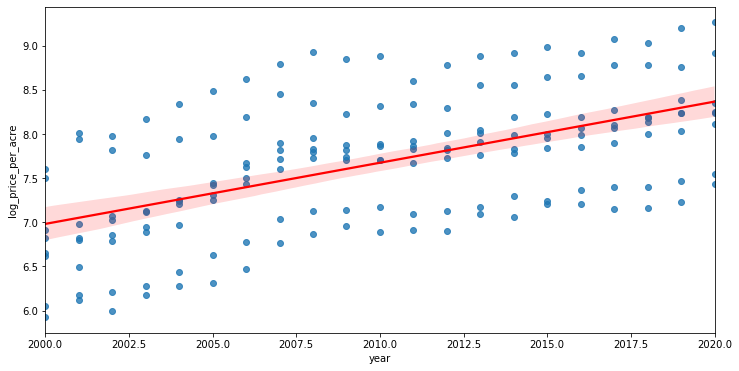

In [30]:
plt.figure(figsize=(12,6))
sns.regplot(data=last_20_menard_area, x='year', y='log_price_per_acre', line_kws={'color': 'red'})

In [31]:
prediction_df = (pd.DataFrame(data={'year': [2020, 2040]}, 
                             columns=last_20_menard_area_with_dummies.columns)
                  .drop('log_price_per_acre', axis=1)
                  .fillna(0))
        
preds = reg.predict(prediction_df)
np.exp(preds)

array([ 4304.81664872, 17199.78829818])

This indicates the current average price per acre for the specific Menard area with recent data is `$4,304` with an expected value of `$17,199` in 2040, or an ARR of 7.17%

### Linear regression for the menard area only (Last 20 years)

In [23]:
last_20_menard = menard_area[(menard_area['year'] >= 2000)]

In [24]:
last_20_menard_with_dummies = pd.get_dummies(last_20_menard)
X = last_20_menard_with_dummies.drop('log_price_per_acre', axis=1)
y = last_20_menard_with_dummies['log_price_per_acre']
reg.fit(X, y)
reg.score(X, y)

0.8651659617248232

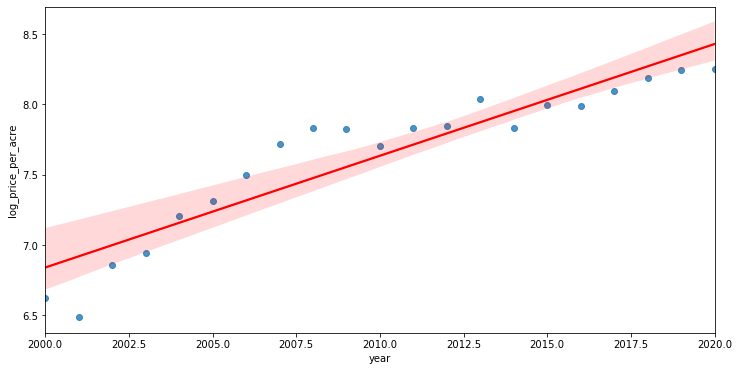

In [25]:
plt.figure(figsize=(12,6))
sns.regplot(data=last_20_menard, x='year', y='log_price_per_acre', line_kws={'color': 'red'})

In [26]:
prediction_df = (pd.DataFrame(data={'year': [2020, 2040]}, 
                             columns=last_20_menard_with_dummies.columns)
                  .drop('log_price_per_acre', axis=1)
                  .fillna(0))
        
preds = reg.predict(prediction_df)
np.exp(preds)

array([ 4579.23830033, 22420.13468533])

This indicates the current average price per acre for the specific Menard area with recent data is `$4,579` with an expected value of `$22,420` in 2040, or an ARR of 8.27%